# A Script for finding relative pose between images

This script works with images that always intersects

# Part I. Preparation

First, we load the dataset. This might take a couple minutes.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import load_data
import time
import traditional
from tqdm import tqdm

import matplotlib.pyplot as plt

%matplotlib inline

Some extra arguments

In [2]:
def parse_args():
    
    """
    Parse input arguments
    """
    args = {"dataset_path": '/media/ilnn/HDD4T/IPDataset2018',
            "dataset": 'bottom_diff_cameras',
            "start_epoch": 1,
            "max_epochs": 25,
            "disp_interval": 100,
            "checkpoint_interval": 10000,
            "save_dir": "models",
            "num_workers": 0,
            "cuda": True,
            "batch_size": 10,
            "shuffle": True,
            # config optimization
            "optimizer": 'sgd',
            "lr": 0.001,
            "lr_decay_step": 5,
            "lr_decay_gamma": 0.1,
            # set training session
            "session": 1,
            # resume trained model
            "resume": False,
            "checksession": 1,
            "checkepoch": 1,
            "checkpoint": 0   
           }
    return args

In [3]:
args = parse_args()
print('Called with args:')
print(args)

Called with args:
{'dataset_path': '/media/ilnn/HDD4T/IPDataset2018', 'dataset': 'bottom_diff_cameras', 'start_epoch': 1, 'max_epochs': 25, 'disp_interval': 100, 'checkpoint_interval': 10000, 'save_dir': 'models', 'num_workers': 0, 'cuda': True, 'batch_size': 10, 'shuffle': True, 'optimizer': 'sgd', 'lr': 0.001, 'lr_decay_step': 5, 'lr_decay_gamma': 0.1, 'session': 1, 'resume': False, 'checksession': 1, 'checkepoch': 1, 'checkpoint': 0}


In [4]:
if torch.cuda.is_available() and not args['cuda']:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        load_data.ToTensor(),
        load_data.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225] )
        
    ]),
    'val': transforms.Compose([
        load_data.ToTensor(),
        load_data.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
    ]),
}


images_dataset = os.path.join(args['dataset_path'], args['dataset'])
annotations_dataset ='files_list.csv'

pose_dataset = {x: load_data.RelativePoseDataset(csv_file=annotations_dataset, root_dir=images_dataset, 
                transform=data_transforms[x], dataset_type=x)
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader( pose_dataset[x], batch_size = args['batch_size'],
                shuffle=args['shuffle'], num_workers=args['num_workers'] )
                for x in ['train', 'val']}

dataset_sizes = {x: len(pose_dataset[x]) for x in ['train', 'val']}

#check that sizes are correct!
print(dataset_sizes)


{'train': 6750, 'val': 750}


- Visualize a few images
 * Let's visualize a few training images so as to understand the data augmentations.

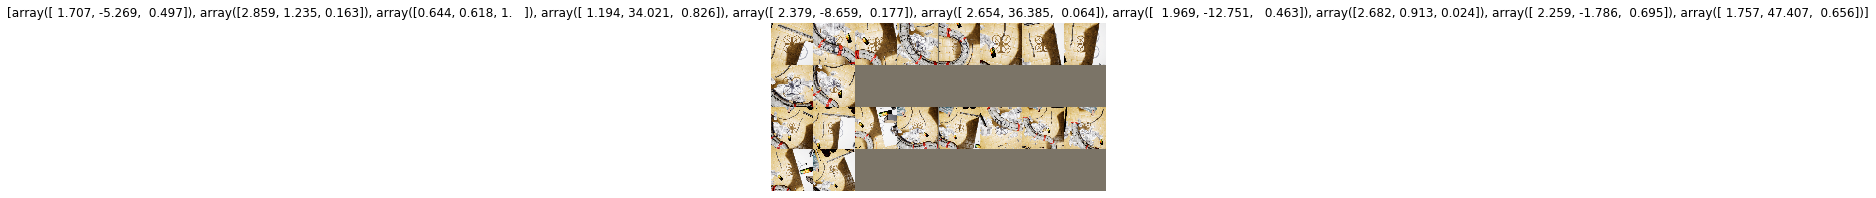

In [6]:
# Get a batch of training data and show it

load_data.show_batch( next(iter(dataloaders['train'])) )


Part II. Training the model
-------------------------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [7]:
def train_model(train, model, criterion, optimizer, scheduler, num_epochs=25):

    best_acc = np.inf
    best_model = {}
    
    if train:
        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    #scheduler.step()
                    # Set model to training mode
                    model['conv1'].train()
                    model['conv2'].train()
                    model['fc'].train()
                else:
                    # Set model to evaluate mode
                    model['conv1'].eval()
                    model['conv2'].eval()
                    model['fc'].eval()
                
                if args['cuda']:
                    model['conv1'].cuda()
                    model['conv2'].cuda()
                    model['fc'].cuda()

                running_loss = 0.0
                running_corrects = 0
                # Iterate over data.
                data_iter = iter(dataloaders[phase])
                
                for step in tqdm(range( int(dataset_sizes[phase] / args['batch_size']) )):
                    batch = next(data_iter)
                
                #for batch in dataloaders[phase]:  
                #    step += 1
                    
                    if args['cuda']:
                        img1 = batch['image1'].cuda()
                        img2 = batch['image2'].cuda()
                        relative = batch['relative'].cuda()
                    relative = relative.to(dtype=torch.float32)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        conv1 = model['conv1'](img1)
                        conv2 = model['conv2'](img2)
                        #print(conv2.shape)
                        # concatenate
                        fcn = torch.cat((conv1,conv2), 1)
                        outputs = model['fc'](fcn)
                        
                        loss = criterion(outputs, relative)
                        
                         # statistics
                        if phase == 'val':
                            running_corrects += loss.item()
                        
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            running_loss += loss.item()
                    
                    if step % int( args['disp_interval'] / args['batch_size']) == 0 and phase == 'train':
                        tqdm.write("(epoch %2d) loss: %.4f" % (epoch,  running_loss / (step+1) ) )

            epoch_acc = running_corrects / dataset_sizes[phase]
            # deep copy the model
            if epoch_acc < best_acc:
                best_acc = epoch_acc
                best_model = model
                    
            tqdm.write("(epoch %2d) acc: %.4f, best_acc: %.4f" % (epoch, epoch_acc, best_acc) )
        
    else:
        # load best model weights
        output_dir = args['save_dir'] + "/" + args['dataset']
        net = os.path.join(output_dir, 'conv1.pt')
        model['conv1'].load_state_dict(torch.load( net ))
        
        net = os.path.join(output_dir, 'conv2.pt')
        model['conv2'].load_state_dict(torch.load( net ))
        
        net = os.path.join(output_dir, 'fc.pt')
        model['fc'].load_state_dict(torch.load( net ))
        
        best_model = model
        
    return best_model, best_acc

Finetuning the convnet
----------------------

First, a identity function is defined...


In [8]:
class IdentityModule(nn.Module):
    def forward(self, inputs):
        return inputs

Load a pretrained model and reset final fully connected layer.

In [9]:
def init_net():
    
    model = {'conv1': models.resnet18(pretrained=True), 'conv2': models.resnet18(pretrained=True), 'fc': nn.Linear(2*512, 3) }

    model['conv1'].fc = IdentityModule()
    model['conv2'].fc = IdentityModule()

    criterion = nn.MSELoss(size_average=False)

    # Observe that all parameters are being optimized
    parameters = list(model['conv1'].parameters()) + list(model['conv2'].parameters()) + list(model['fc'].parameters())
    
    return model, criterion, parameters


Train and evaluate 
----------------------

If you select train=True, a eelection of random values for hyperparameters in order to get better perfomarnce.
It should take around 15-25 min.

In [10]:
train = False
if train:
    max_learning_iterations = 8    
    best_acc = np.inf
    result = {}

    for learning_ in range(max_learning_iterations):
        
        learning = np.random.uniform(1e-5, 1e-3, 1)
        print('learning rate :', learning[0])
        
        model, criterion, parameters = init_net()
        
        optimizer_ft = optim.Adam(parameters, lr=learning[0])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 5, gamma = 0.1)
        
        model, acc = train_model(True, model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=args['max_epochs'])

        if acc < best_acc:
            best_acc = acc
            result['model'] = model
            result['learning'] = learning[0]

    print('best overal acc : ', best_acc)
    model = result['model']
    
    output_dir = args['save_dir'] + "/" + args['dataset']
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    net = os.path.join(output_dir, 'conv1.pt')
    torch.save(model['conv1'].state_dict(), net )
    
    net = os.path.join(output_dir, 'conv2.pt')
    torch.save(model['conv2'].state_dict(), net )
    
    net = os.path.join(output_dir, 'fc.pt')
    torch.save(model['fc'].state_dict(), net)
    

#### Visualizing the model predictions

Generic function to display predictions for a few images

In [11]:
def visualize_model( model, batch_num=6, compare=False):
    
    model['conv1'].eval()
    model['conv2'].eval()
    model['fc'].eval()
    
    data_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for batch in dataloaders['val']:

            if args['cuda']:
                model['conv1'].cuda()
                model['conv2'].cuda()
                model['fc'].cuda()
            if args['cuda']:
                img1 = batch['image1'].cuda()
                img2 = batch['image2'].cuda()
                relative = batch['relative'].cuda()
            relative = relative.to(dtype=torch.float32)

            conv1 = model['conv1'](img1)
            conv2 = model['conv2'](img2)
            # concatenate
            fcn = torch.cat((conv1,conv2), 1)
            outputs = model['fc'](fcn)
    
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            for j in range(len(img1)):
                data_so_far += 1
                name_ = outputs.cpu().data[j]    
                name_[1] = name_[1]*180/3.14159
                title =  np.around(name_.numpy().tolist(),3) 
                name2_ = relative.cpu().data[j]
                name2_[1] = name2_[1]*180/3.14159
                title2_ =  np.around(name2_.numpy().tolist(),3) 
                
                plt.figure()
        
                img_ = img1.cpu().data[j]
                img_ = img_.numpy().transpose((1, 2, 0))
                img_ = std * img_ + mean
                img_ = np.clip(img_, 0, 1)
                
                img2_ = img2.cpu().data[j]
                img2_ = img2_.numpy().transpose((1, 2, 0))
                img2_ = std * img2_ + mean
                img2_ = np.clip(img2_, 0, 1)

                grid = np.hstack( (img_, img2_) )
                plt.imshow(grid)
                
                plt.axis('off')
                plt.ioff()
                plt.show()
                np.set_printoptions(suppress=True)
                print("RGT : ", title2_)
                print("CNN : ", title)
                
                if compare:
                    translation, rotation = traditional.get_pose(img_,img2_)
                    title3_ = np.around([translation, rotation],3) 
                    print("TCV : ", title3_)
        
                if data_so_far == batch_num:
                    return

Use the best params to train more time if train was set ...

In [12]:
model, criterion, parameters = init_net()
optimizer_ft = optim.Adam(parameters, lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
model, acc = train_model(False, model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=120)

<Figure size 432x288 with 0 Axes>

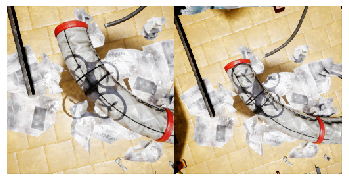

RGT :  [0.384 6.529 0.899]
CNN :  [0.557 8.926 0.899]
TCV :  [ 0.39  -0.407]


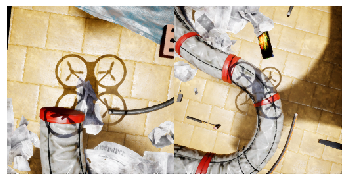

RGT :  [ 3.287 -7.055  0.374]
CNN :  [ 3.384 -5.1    0.426]
Not enough matches are found - %d/%d 6 10
TCV :  [0 0]


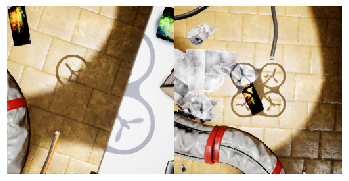

RGT :  [ 1.324 14.909  0.423]
CNN :  [ 1.999 14.653  0.287]
Not enough matches are found - %d/%d 1 10
TCV :  [0 0]


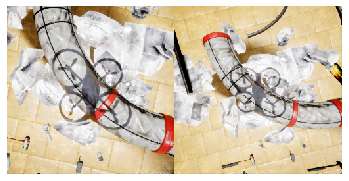

RGT :  [ 0.544 26.498  0.775]
CNN :  [ 2.972 29.562  0.173]
TCV :  [ 0.578 -2.229]


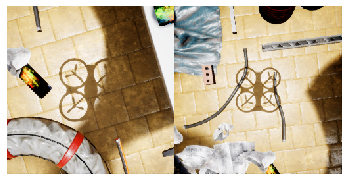

RGT :  [ 2.42  -9.439  0.133]
CNN :  [  1.385 -13.176   0.457]
Not enough matches are found - %d/%d 4 10
TCV :  [0 0]


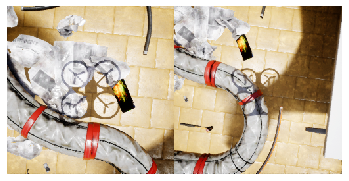

RGT :  [ 1.352 -2.196  1.   ]
CNN :  [ 1.802 -5.144  0.972]
TCV :  [ 1.019 33.407]


In [21]:
visualize_model(model, compare=True)